# Imports & basic configuration

In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/branch_full/deep_branching"
except:
    pass

import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from branch import Net
from galerkin import DGMNet
from bsde import BSDENet
import logging

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# perfect reproducibility is not guaranteed with different version of torch
#
import torchaudio
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchaudio version: {torchaudio.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.10.0+cu111
torchaudio version: 0.10.0+cu111
torchvision version: 0.11.1+cu111


In [ ]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Tue Mar 22 09:07:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    38W / 250W |  11529MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [2]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    **kwargs,
):
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)

    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "log/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "log/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "log/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "log/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

# Kuramoto-Sivashinsky equation - example 1

## T=.5

In [16]:
alpha, beta, gamma = 1, 4, 1

# function definition
deriv_map = np.array([0, 1, 2, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    idx 3 -> third deriv
    idx 4 -> forth deriv
    """
    return -y[0] * y[1] - (alpha + .5) * y[2]- beta * y[3] - gamma * y[4]

def phi_example(x):
    theta = -.5 * x[0]
    return (
        11
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    theta = -.5 * x[0] + (T - t)
    return (
        11
        + 15 * np.tanh(theta)
        - 15 * (np.tanh(theta))**2
        - 15 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 161.3125238418579 seconds.


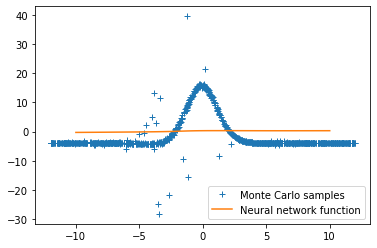

Patch 0: epoch 0 with loss 39.86481475830078


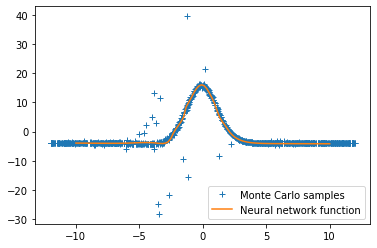

Patch 0: epoch 500 with loss 4.231273651123047


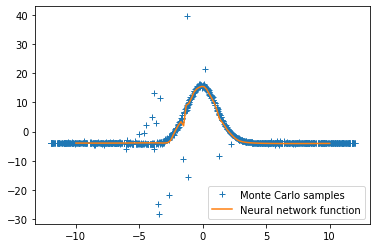

Patch 0: epoch 1000 with loss 4.136543273925781


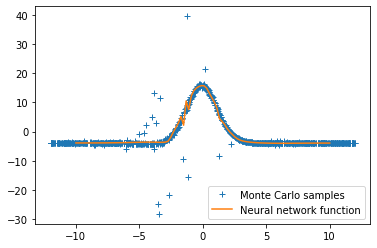

Patch 0: epoch 1500 with loss 3.8900413513183594


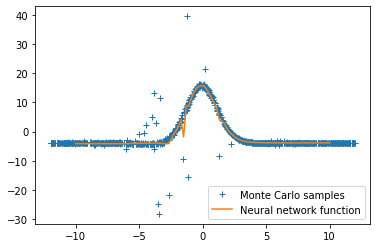

Patch 0: epoch 2000 with loss 3.6641430854797363


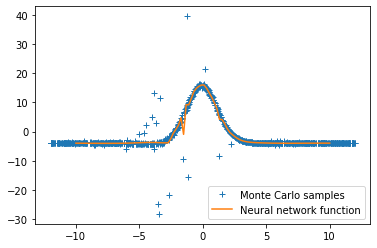

Patch 0: epoch 2500 with loss 3.635897636413574


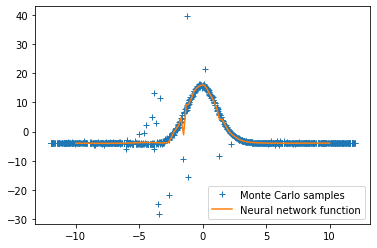

Patch 0: epoch 2999 with loss 3.6148414611816406
Patch 0: training of neural network with 3000 epochs take 10.300232648849487 seconds.
Time taken: 171 seconds; L1 error: 7.48E-01; L2 error: 2.04E+00; rel error: 2.99E-01.
fdb runtime: 1 seconds; total runtime: 172 seconds.




######## Summary for deep branching method
runtime:        171
fdb runtime:    1
total runtime:  172
mean L1 error:  7.48E-01
std L1 error:   0.00E+00
mean L2 error:  2.04E+00
std L2 error:   0.00E+00
mean rel error: 2.99E-01
std rel error:  0.00E+00


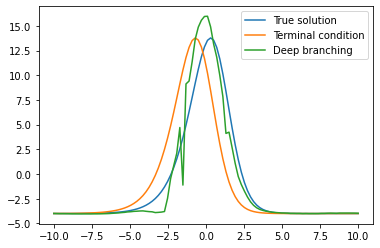

In [22]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="kuramoto-sivashinsky",
                    branch_nb_states=1000, branch_nb_path_per_state=5000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

## T=.05

In [28]:
alpha, beta, gamma = 1, 4, 1

# function definition
deriv_map = np.array([0, 1, 2, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    idx 3 -> third deriv
    idx 4 -> forth deriv
    """
    return -y[0] * y[1] - (alpha + .5) * y[2]- beta * y[3] - gamma * y[4]

def phi_example(x):
    theta = -.5 * x[0]
    return (
        11
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    theta = -.5 * x[0] + (T - t)
    return (
        11
        + 15 * np.tanh(theta)
        - 15 * (np.tanh(theta))**2
        - 15 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .05
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 157.54584050178528 seconds.


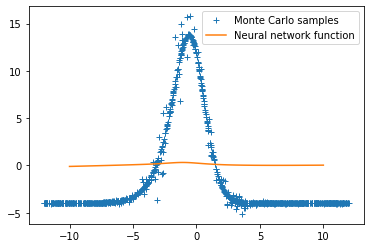

Patch 0: epoch 0 with loss 29.516094207763672


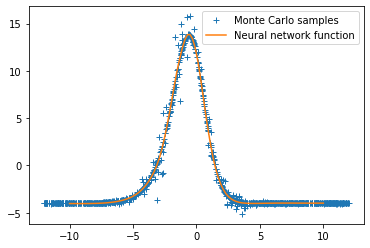

Patch 0: epoch 500 with loss 0.17413678765296936


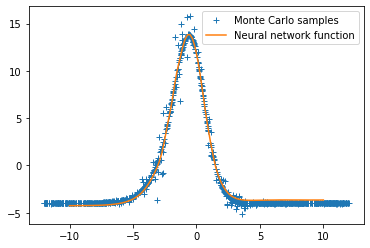

Patch 0: epoch 1000 with loss 0.1878311187028885


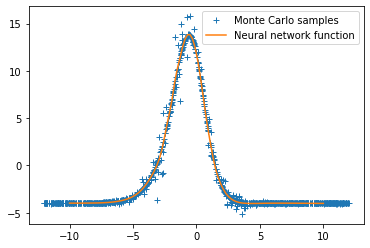

Patch 0: epoch 1500 with loss 0.17177189886569977


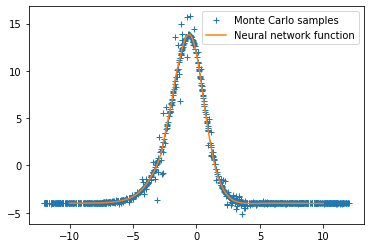

Patch 0: epoch 2000 with loss 0.17140814661979675


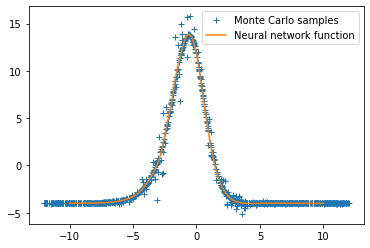

Patch 0: epoch 2500 with loss 0.17145413160324097


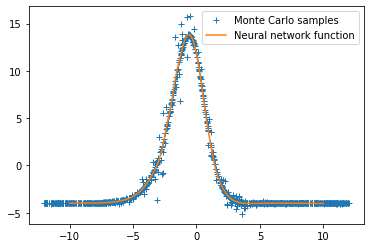

Patch 0: epoch 2999 with loss 0.17136438190937042
Patch 0: training of neural network with 3000 epochs take 10.248147964477539 seconds.
Time taken: 167 seconds; L1 error: 4.74E-02; L2 error: 8.20E-03; rel error: 3.01E-02.
fdb runtime: 1 seconds; total runtime: 168 seconds.




######## Summary for deep branching method
runtime:        167
fdb runtime:    1
total runtime:  168
mean L1 error:  4.74E-02
std L1 error:   0.00E+00
mean L2 error:  8.20E-03
std L2 error:   0.00E+00
mean rel error: 3.01E-02
std rel error:  0.00E+00


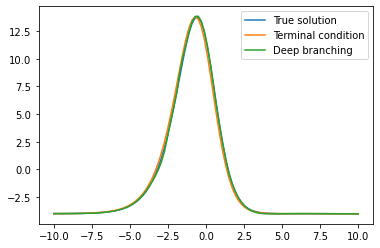

In [29]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="kuramoto-sivashinsky",
                    branch_nb_states=1000, branch_nb_path_per_state=5000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# Kuramoto-Sivashinsky equation - example 3

## T=.5

In [24]:
alpha, beta, gamma = 1, .0, .5

# function definition
deriv_map = np.array([0, 1, 2, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    idx 3 -> third deriv
    idx 4 -> forth deriv
    """
    return -y[0] * y[1] - (alpha + .5) * y[2]- beta * y[3] - gamma * y[4]

def phi_example(x):
    kappa = .5 * math.sqrt(11 * alpha / (19 * gamma))
    theta = kappa * x[0]
    return (
        -0.1 / kappa 
        + 60 / 19 * kappa * (-38 * gamma * kappa**2 + alpha) * torch.tanh(theta) 
        + 120 * gamma * kappa**3 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    kappa = .5 * math.sqrt(11 * alpha / (19 * gamma))
    theta = kappa * x[0] + .1 * (T - t)
    return (
        -0.1 / kappa 
        + 60 / 19 * kappa * (-38 * gamma * kappa**2 + alpha) * np.tanh(theta) 
        + 120 * gamma * kappa**3 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 136.49761033058167 seconds.


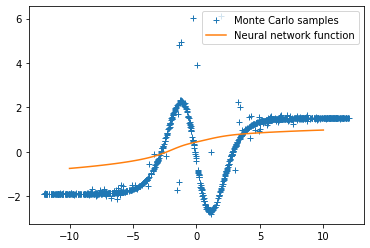

Patch 0: epoch 0 with loss 2.9177589416503906


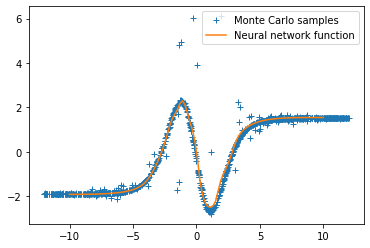

Patch 0: epoch 500 with loss 0.15935806930065155


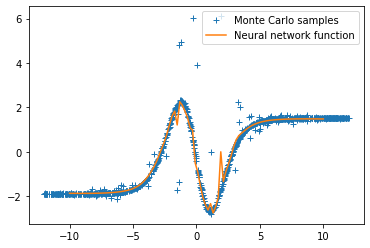

Patch 0: epoch 1000 with loss 0.13473479449748993


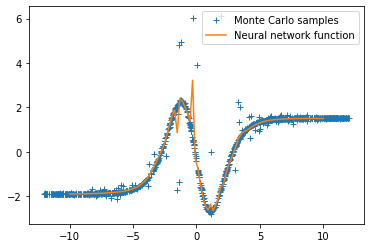

Patch 0: epoch 1500 with loss 0.1095966249704361


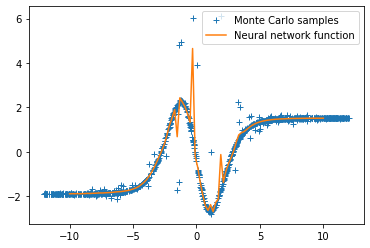

Patch 0: epoch 2000 with loss 0.08885902911424637


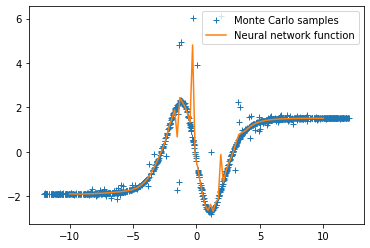

Patch 0: epoch 2500 with loss 0.08710905909538269


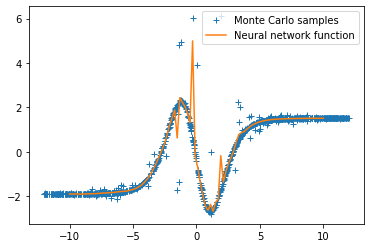

Patch 0: epoch 2999 with loss 0.0854891836643219
Patch 0: training of neural network with 3000 epochs take 10.407729148864746 seconds.
Time taken: 146 seconds; L1 error: 1.22E-01; L2 error: 2.44E-01; rel error: 1.45E-01.
fdb runtime: 1 seconds; total runtime: 147 seconds.




######## Summary for deep branching method
runtime:        146
fdb runtime:    1
total runtime:  147
mean L1 error:  1.22E-01
std L1 error:   0.00E+00
mean L2 error:  2.44E-01
std L2 error:   0.00E+00
mean rel error: 1.45E-01
std rel error:  0.00E+00


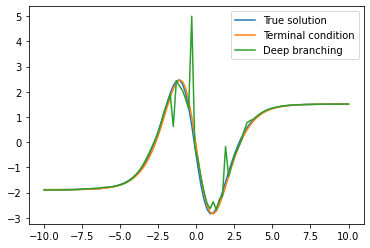

In [25]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="kuramoto-sivashinsky",
                    branch_nb_states=1000, branch_nb_path_per_state=5000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

## T=.05

In [34]:
alpha, beta, gamma = 1, .0, .5

# function definition
deriv_map = np.array([0, 1, 2, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    idx 3 -> third deriv
    idx 4 -> forth deriv
    """
    return -y[0] * y[1] - (alpha + .5) * y[2]- beta * y[3] - gamma * y[4]

def phi_example(x):
    kappa = .5 * math.sqrt(11 * alpha / (19 * gamma))
    theta = kappa * x[0]
    return (
        -0.1 / kappa 
        + 60 / 19 * kappa * (-38 * gamma * kappa**2 + alpha) * torch.tanh(theta) 
        + 120 * gamma * kappa**3 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    kappa = .5 * math.sqrt(11 * alpha / (19 * gamma))
    theta = kappa * x[0] + .1 * (T - t)
    return (
        -0.1 / kappa 
        + 60 / 19 * kappa * (-38 * gamma * kappa**2 + alpha) * np.tanh(theta) 
        + 120 * gamma * kappa**3 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .05
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 136.52296376228333 seconds.


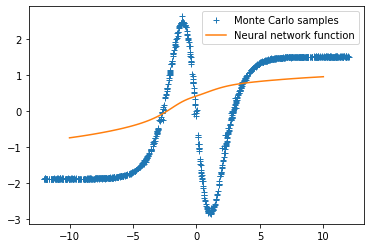

Patch 0: epoch 0 with loss 2.851299524307251


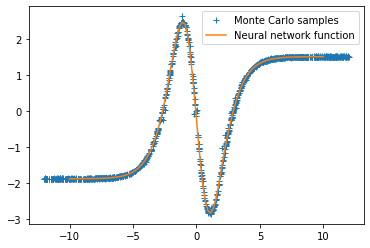

Patch 0: epoch 500 with loss 0.0015764092095196247


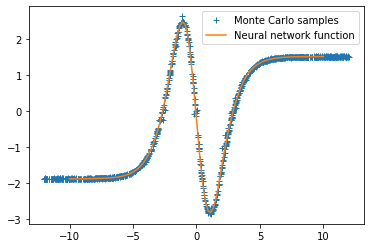

Patch 0: epoch 1000 with loss 0.00160446937661618


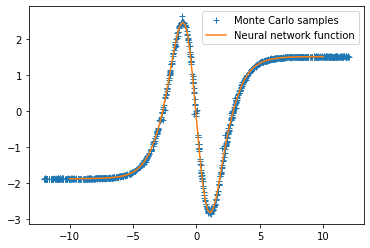

Patch 0: epoch 1500 with loss 0.0015611343551427126


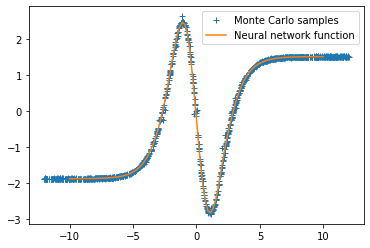

Patch 0: epoch 2000 with loss 0.0015597001183778048


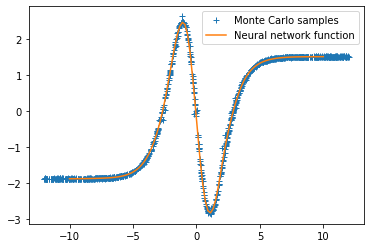

Patch 0: epoch 2500 with loss 0.001561193959787488


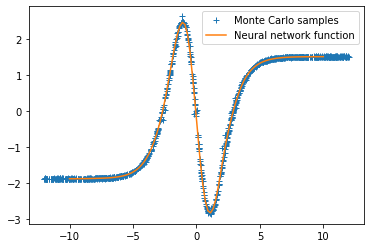

Patch 0: epoch 2999 with loss 0.0015582123305648565
Patch 0: training of neural network with 3000 epochs take 10.417350769042969 seconds.
Time taken: 146 seconds; L1 error: 6.12E-03; L2 error: 1.72E-04; rel error: 8.64E-03.
fdb runtime: 1 seconds; total runtime: 147 seconds.




######## Summary for deep branching method
runtime:        146
fdb runtime:    1
total runtime:  147
mean L1 error:  6.12E-03
std L1 error:   0.00E+00
mean L2 error:  1.72E-04
std L2 error:   0.00E+00
mean rel error: 8.64E-03
std rel error:  0.00E+00


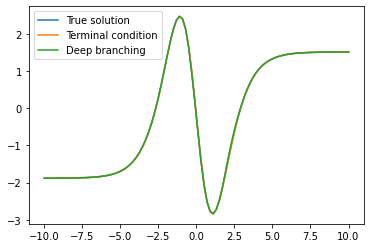

In [35]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="kuramoto-sivashinsky",
                    branch_nb_states=1000, branch_nb_path_per_state=5000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# Gradient of 1-dimensional Allen-Cahn

In [36]:
# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

dgm_deriv_map = np.array([0, 2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> second deriv
    """
    return .5 * y[1] + y[0] - y[0] ** 3

def phi_example(x):
    return -0.5 - 0.5 * torch.nn.Tanh()(-x[0] / 2)

def exact_example(t, x, T):
    return 0.25 * (1 - np.tanh(-x[0]/2 + 3*(T-t)/4)**2)

t_lo, x_lo, x_hi, n = 0., -8., 8., 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 1 times
Patch 0: generation of samples take 10.396223068237305 seconds.


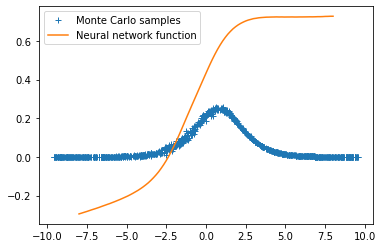

Patch 0: epoch 0 with loss 0.3921620547771454


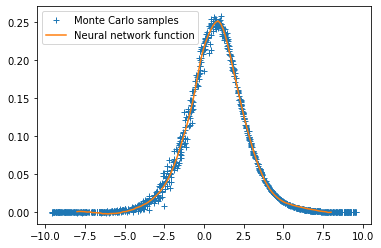

Patch 0: epoch 500 with loss 2.3328673705691472e-05


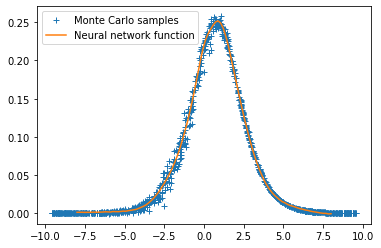

Patch 0: epoch 1000 with loss 2.2917927708476782e-05


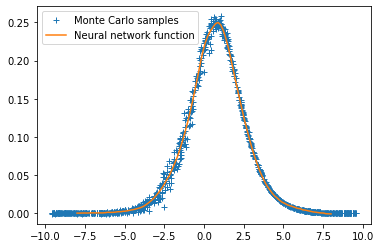

Patch 0: epoch 1500 with loss 2.197835965489503e-05


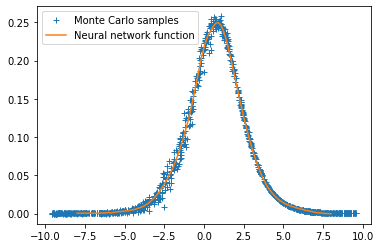

Patch 0: epoch 2000 with loss 2.1880918211536482e-05


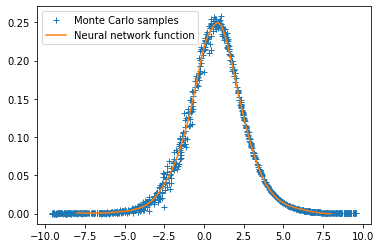

Patch 0: epoch 2500 with loss 2.1962900063954294e-05


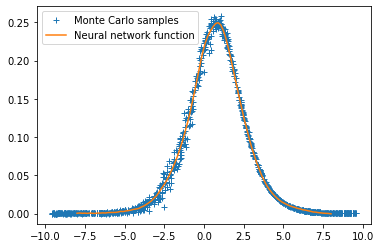

Patch 0: epoch 2999 with loss 2.1890014977543615e-05
Patch 0: training of neural network with 3000 epochs take 10.450318098068237 seconds.
Time taken: 21 seconds; L1 error: 9.34E-04; L2 error: 2.07E-06; rel error: 1.65E-01.
fdb runtime: 0 seconds; total runtime: 21 seconds.




######## Summary for deep branching method
runtime:        21
fdb runtime:    0
total runtime:  21
mean L1 error:  9.34E-04
std L1 error:   0.00E+00
mean L2 error:  2.07E-06
std L2 error:   0.00E+00
mean rel error: 1.65E-01
std rel error:  0.00E+00


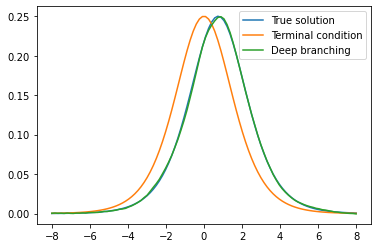

In [37]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn", code=[-2],
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)